1. Необходимо скачать и подготовить датасет
https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks
для обучения модели на сегментацию губ (обратите внимание, что сегментация
подразумевает уже два класса: фон и губы).
2. И затем обучить Модель на выбор из segmentation_models_pytorch

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=990c1ec117c8dde0d4bd270ba73ed90c8c13942a68d9ac3de381105f773fdf40
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3c5da90b008f886abad9b81d9a02cc9936633cece6a30d7a9cf3ac0cbfc7ba73
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
import os
import time
import random

from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import re

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


import segmentation_models_pytorch as smp

In [3]:
!pip install opendatasets

In [4]:
import zipfile

zip_path = root_data_path = '/content/drive/MyDrive/lips/makeup-lips-segmentation-28k-samples/makeup-lips-segmentation-28k-samples.zip'

z = zipfile.ZipFile(zip_path, 'r')

z.extractall()

In [5]:
# пути к данным
root_data_path = '/content/set-lipstick-original'

dataset_file = root_data_path + '/list.csv'
images_path = root_data_path + '/720p/'
masks_path = root_data_path + '/mask/'

In [6]:
# датасет list.csv
df = pd.read_csv(dataset_file)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [7]:
#список имен файлов (картинки и маски)
files_names_list = sorted(os.listdir(images_path))
masks_names_list = sorted(os.listdir(masks_path))
print(f'Количество изображений {len(files_names_list)}')
print(f'Количество масок {len(masks_names_list)}')

Количество изображений 28594
Количество масок 28540


In [8]:
#уберем из датасета строки с именами масок и файлов, которых нет среди загруженных файлов
df = df.loc[df['mask'].isin([i for i in masks_names_list])]
df = df.loc[df['filename'].isin([i for i in files_names_list])]
df.reset_index(drop=True, inplace=True)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


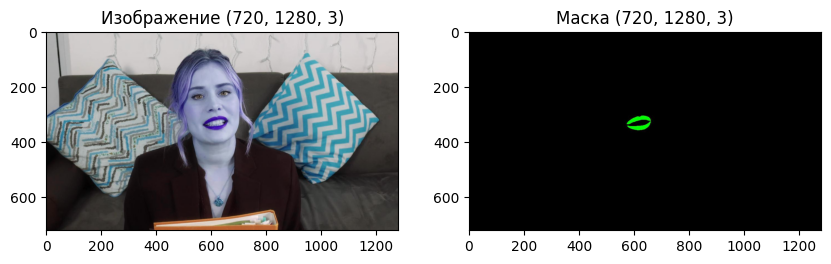

In [9]:
#просмотр загруженных данных

ridx = random.randint(0, df.shape[0])

image = cv2.imread(images_path + files_names_list[ridx], cv2.COLOR_BGR2RGB)
mask = cv2.imread(masks_path + masks_names_list[ridx], cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].set_title(f'Изображение {image.shape}')
ax[1].imshow(mask)
ax[1].set_title(f'Маска {mask.shape}')
plt.show()

In [10]:
#формирование датасета для построения датасета и даталоадера
data = df[['filename', 'mask']]
data.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [11]:
#инициализация модели
segmodel = smp.Linknet(encoder_name = 'resnet34',
                    encoder_weights = 'imagenet',
                    in_channels = 3,
                    classes = 1, # число каналов маски
                    activation = 'sigmoid')

#предобученный декодер модели
preprocess_input = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 70.1MB/s]


In [12]:
#класс датасета
class CustomDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # загружаем данные из датасета
        self.data = data
        self.preprocessing = preprocessing
        self.image_arr = self.data.iloc[:,0] # имена файлов картинок из датасета
        self.label_arr = self.data.iloc[:,1] # имена файлов масок из датасета
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
       # загружаем картинки
        img = cv2.imread(images_path+self.image_arr[index])
        img = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)
        img = np.asarray(img).astype('float')

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)

        else:
            img = torch.as_tensor(img)
            img /= 255.0

        img = img.permute(2,0,1)

        # загружаем маски
        mask = cv2.imread(masks_path+self.label_arr[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        cls_mask = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
        masks = torch.as_tensor(masks, dtype=torch.uint8)


        return (img.float(), masks)

In [13]:
#разделение датасета на train и test
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)

#сбрасываем индексы
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

#создаем датасеты
train_data = CustomDataset(X_train, preprocessing=preprocess_input)
test_data = CustomDataset(X_test, preprocessing=preprocess_input)

#создаем даталодеры
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

<ipython-input-12-40013db7d381>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(-2.0182) tensor(2.5703)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


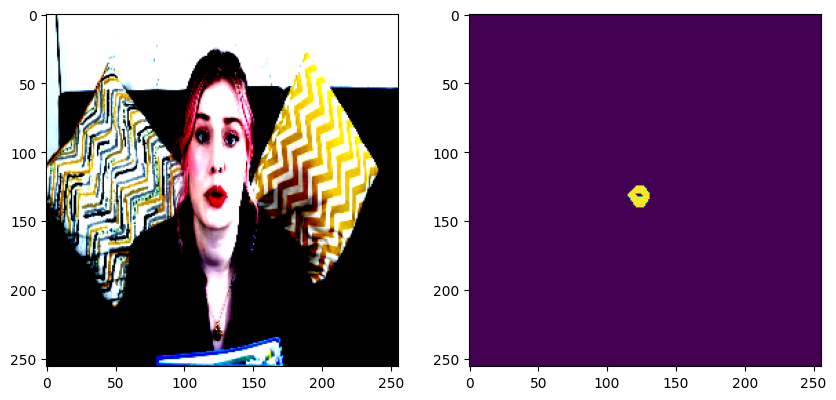

In [14]:
#просмотр данных из даталоадера

for img, target in train_data_loader:
    ridx = random.randint(0, img.shape[0])
    print(img.shape, target.shape)
    print(img[ridx].min(), img[ridx].max())
    print(target[ridx].min(), target[ridx].max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [15]:
class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [16]:
class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)


class Activation(nn.Module):
    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)

In [22]:
import sys
import torch
from tqdm import tqdm as tqdm

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cuda", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cuda", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cuda", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [18]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs

def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x

def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta**2) * tp + eps) / ((1 + beta**2) * tp + beta**2 * fn + fp + eps)

    return score


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union

In [19]:
class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)


class Activation(nn.Module):
    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)


class IoU(nn.Module):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [20]:
class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )

class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)

###Обучение модели Linknet из segmentation_models_pytorch

In [23]:
#определение критерия, метрики и оптимизатора
criterion = DiceLoss()
metrics = [IoU()]
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

#определение тренировочных и валидационных эпох
train_epoch = TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    verbose=True)

valid_epoch = ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    verbose=True)

In [24]:
# обучение модели
num_epochs = 3
linknet_train_iou = []
linknet_valid_iou = []

for i in range(num_epochs):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)

    linknet_train_iou.append(train_logs['iou_score'])
    linknet_valid_iou.append(valid_logs['iou_score'])

Epoch: 1
valid: 100%|██████████| 2141/2141 [06:39<00:00,  5.36it/s, dice_loss - 0.04885, iou_score - 0.9097]
Epoch: 2
valid: 100%|██████████| 2141/2141 [06:33<00:00,  5.45it/s, dice_loss - 0.03208, iou_score - 0.9387]
Epoch: 3
valid: 100%|██████████| 2141/2141 [06:31<00:00,  5.46it/s, dice_loss - 0.02954, iou_score - 0.9432]


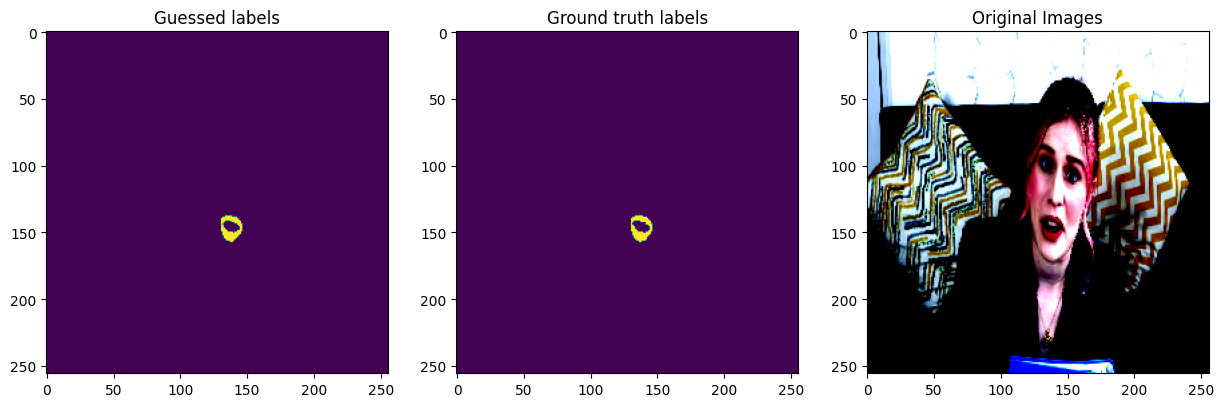

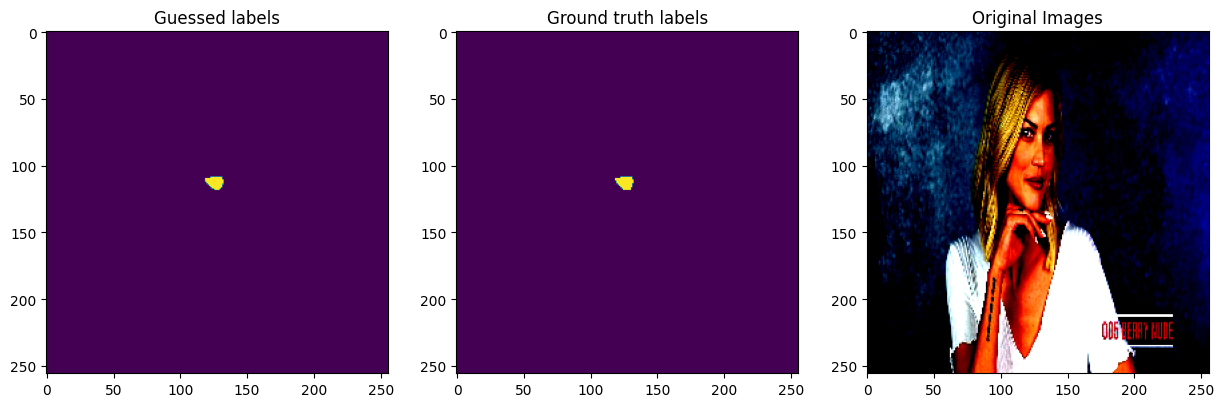

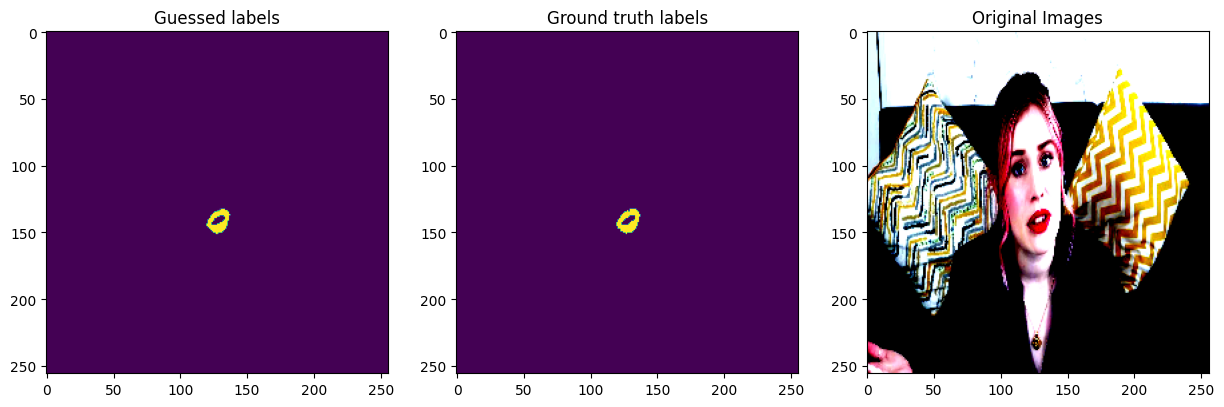

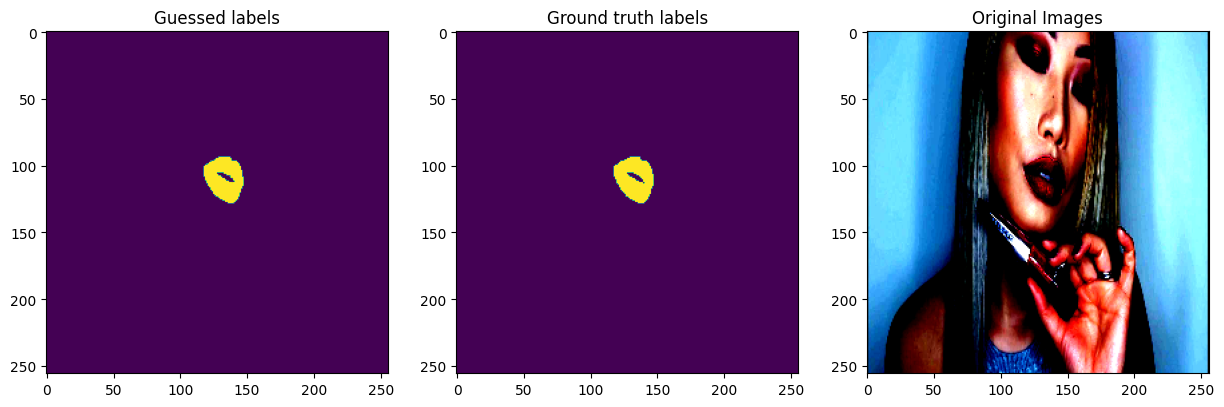

In [34]:
#предсказание модели
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images
    labels = labels

    outputs = segmodel(images.cuda())

    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels[i, ].cpu().permute(1, 2, 0))
        axarr[1].set_title('Ground truth labels')

        image = images[i].permute(1, 2, 0)
        axarr[2].imshow(image.cpu())
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 2:
        break